# 2D case - # 2D case - Space variability solution plots
Two-parameter 2D problem - Pyvista plots

## Libraries import  

In [1]:

import sys  
import torch
import torch.nn as nn
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
import neurom.src.Pre_processing as pre
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
from neurom.src.Training import Training_NeuROM_multi_level
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
from importlib import reload  
import tomllib
import numpy as np
import argparse

torch.manual_seed(0)

* WARNING: could not load tikzplotlib


## Load the config file

In [2]:
    Configuration_file = 'Configurations/config_2D_ROM_SV.toml'

    with open(Configuration_file, mode="rb") as file:
        config = tomllib.load(file)

## Definition of the space domain and mechanical proprieties of the structure

The initial Material parameters, the geometry, mesh and the boundary conditions are set. 

In [3]:

# Material parameters definition

Mat = pre.Material(             flag_lame = False,                                  # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],                # Young Modulus
                                coef2     = config["material"]["nu"]                # Poisson's ratio
                )

MaxElemSize2D = config["interpolation"]["MaxElemSize2D"] = 0.5
# config["training"]["multiscl_max_refinment"] = 1

# Create mesh object
MaxElemSize = pre.ElementSize(
                                dimension     = config["interpolation"]["dimension"],
                                L             = config["geometry"]["L"],
                                order         = config["interpolation"]["order"],
                                np            = config["interpolation"]["np"],
                                MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                            )
Excluded = []
Mesh_object = pre.Mesh( 
                                config["geometry"]["Name"],                         # Create the mesh object
                                MaxElemSize, 
                                config["interpolation"]["order"], 
                                config["interpolation"]["dimension"]
                        )

Mesh_object.AddBorders(config["Borders"]["Borders"])
Mesh_object.AddBCs(                                                                 # Include Boundary physical domains infos (BCs+volume)
                                config["geometry"]["Volume_element"],
                                Excluded,
                                config["DirichletDictionryList"]
                    )                   

Mesh_object.MeshGeo()                                                               # Mesh the .geo file if .msh does not exist
Mesh_object.ReadMesh()       
Mesh_object.ExportMeshVtk()

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  3.1.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           434



## Parametric study definition

The hypercube describing the parametric domain used for the tensor decomposition is set-up here

In [4]:
ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                        config["parameters"]["para_1_max"],
                                        config["parameters"]["N_para_1"]],
                                    [   config["parameters"]["para_2_min"],
                                        config["parameters"]["para_2_max"],
                                        config["parameters"]["N_para_2"]]])

## Initialisation of the surrogate model

In [5]:
ROM_model = NeuROM(                                                                 # Build the surrogate (reduced-order) model
                    Mesh_object, 
                    ParameterHypercube, 
                    config,
                    config["solver"]["n_modes_ini"],
                    config["solver"]["n_modes_max"]
                    )

## Initialisation from pre-trained model


In [8]:
ROM_model.load_state_dict(torch.load('Pretrained_models/2D_ROM_SV', weights_only=False))


<All keys matched successfully>

## Training the model

In [7]:
# ROM_model.Freeze_Mesh()                                                             # Set space mesh coordinates as untrainable
# ROM_model.Freeze_MeshPara()                                                         # Set parameters mesh coordinates as untrainable
# ROM_model.TrainingParameters(   
#                                 loss_decrease_c = config["training"]["loss_decrease_c"], 
#                                 Max_epochs = config["training"]["n_epochs"], 
#                                 learning_rate = config["training"]["learning_rate"]
#                             )

# ROM_model.train()                                                                   # Put the model in training mode
# ROM_model, Mesh_object = Training_NeuROM_multi_level(ROM_model,config, Mat)         

# ROM_model.load_state_dict(torch.load('Pretrained_models/2D_ROM_SV', weights_only=False))

* Refinement level: 0

**************** START TRAINING ***************

epoch 100 loss = -3.58381e-03 modes = 11


KeyboardInterrupt: 

## Pyvista plots

Plot the solution and the error with regard to the Finite Element solution

In [9]:
eval_coord =  torch.tensor(ROM_model.Space_modes[0].mesh.Nodes, dtype=torch.float64, requires_grad=True)[:,1:]


E_vect = [0.0038,0.00314,0.00462]
alpha_vect = [4.21,0,0.82]

error_vect = []
for i in range(len(E_vect)):



    alpha = torch.tensor([alpha_vect[i]],dtype=torch.float64)
    alpha = alpha[:,None] 

    E = torch.tensor([E_vect[i]],dtype=torch.float64)
    E = E[:,None] 


    Para_coord_list = nn.ParameterList((E,alpha))
    ROM_model.eval()                                                        # Put model in evaluation mode
    u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model

    u_sol_x = u_sol[0,:,0,0]
    u_sol_y = u_sol[1,:,0,0]

In [10]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
import torch.nn as nn

pv.global_theme.font.family = 'times'                                           # Arial, courier or times
pv.global_theme.font.size = 40
pv.global_theme.font.title_size = 40
pv.global_theme.font.label_size = 40
pv.global_theme.font.fmt = '%.2e'


filename = 'Geometries/'+Mesh_object.name_mesh                                  # Load mesh (used for projecting the solution only) 
mesh = pv.read(filename)                                                        # Create pyvista mesh    
Nodes = np.stack(Mesh_object.Nodes)  
import matplotlib
matplotlib.rcParams["font.size"] = "25"


## First parameters set

E = 0.005, alpha = 2.5


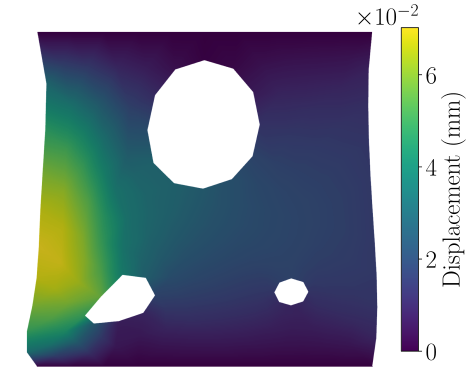

In [11]:
#Fig a)

name = 'a'

alpha_i = 2.5
E_i = 0.005

print(f'E = {E_i}, alpha = {alpha_i}')

alpha = torch.tensor([alpha_i],dtype=torch.float64)
alpha = alpha[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,alpha))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)


mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data


## Result a)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=20,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()
import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_SV_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)


## Second parameters set

E = 0.005, alpha = 5


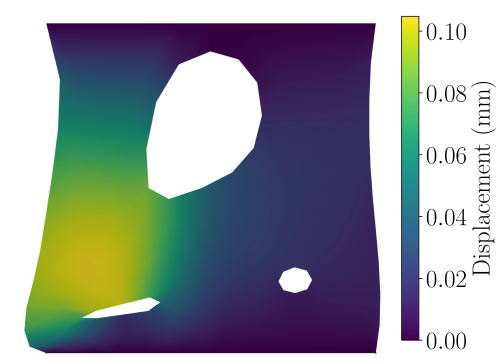

In [12]:
#Fig b)

name = 'b'

alpha_i = 5
E_i = 0.005

print(f'E = {E_i}, alpha = {alpha_i}')

alpha = torch.tensor([alpha_i],dtype=torch.float64)
alpha = alpha[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,alpha))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)


mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data


## Result b)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=20,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()
import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_SV_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)


## Third parameters set

E = 0.005, alpha = 8


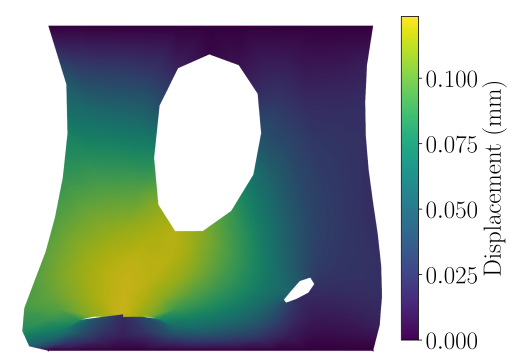

In [13]:
#Fig c)

name = 'c'

alpha_i = 8
E_i = 0.005

print(f'E = {E_i}, alpha = {alpha_i}')

alpha = torch.tensor([alpha_i],dtype=torch.float64)
alpha = alpha[:,None] 

E = torch.tensor([E_i],dtype=torch.float64)
E = E[:,None] 


Para_coord_list = nn.ParameterList((E,alpha))
ROM_model.eval()                                                        # Put model in evaluation mode
u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model
u = torch.stack([(u_sol[0,:,0,0]),(u_sol[1,:,0,0]),torch.zeros(u_sol[0,:,0,0].shape[0])],dim=1)


mesh.point_data['U'] = u.data
mesh.point_data['U_norm'] = torch.norm(u, dim=1).data
mesh.point_data['Ux'] = u[:,0].data
mesh.point_data['Uy'] = u[:,1].data
mesh.point_data['Uz'] = u[:,2].data


## Result c)
plotter = pv.Plotter(off_screen=True)
plotter.add_mesh(mesh.warp_by_vector(vectors="U",factor=20,inplace=False), scalars='U_norm', cmap='viridis', show_scalar_bar=False)

plotter.view_xy()
import matplotlib
image = plotter.screenshot(transparent_background=True,return_img=True, window_size=[3200, 1800])  # Return image as array for Matplotlib
with PdfPages('Results/Fig_pyvista_SV_'+name+'.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(8, 9), dpi = 300)
    plt.imshow(image)
    plt.xlim(900, 2500)
    plt.ylim(1500,250)
    # ax.imshow(image)
    plt.axis('off')  
    
    # fig.subplots_adjust(right=1)  
    cbar_ax = fig.add_axes([0.81, 0.25, 0.03, 0.5]) 
    
    # Normalize scalar field values for the color bar
    norm = Normalize(vmin=mesh.point_data['U_norm'].min(), vmax=mesh.point_data['U_norm'].max())
    # cmap = cm.get_cmap('viridis')
    cmap = matplotlib.colormaps['viridis']

    # Add a color bar based on the normalization and the colormap
    cbar = ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cbar.set_label('Displacement (mm)', fontsize=25)
    cbar.formatter.set_powerlimits((-2, 2))  # Use scientific notation for ticks outside this range
    cbar.update_ticks()  # Update the ticks after setting the formatter
    
    # Save the figure as a vectorized PDF
    pdf.savefig(fig,bbox_inches = 'tight',pad_inches = 0)
    plt.show(fig)
    plt.close(fig)
